# Modelling Exploration Notebook V1

This Notebook focuses on comparing different forecast models provided by GluonTS. <br /> 
Experiments were run using Python 3.9 and PyTorch 1.13. <br /> 
Compared were:
- DeepAR (Salinas et al. 2020): [torch impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py)
- DeepState (Rangapuram et al. 2018): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py)
- MQ-CNN (Wen et al. 2017): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py)

In [26]:
# Required Packages
# !pip install -r ./src/requirements.txt

In [27]:
# Imports experiment script
from src.forecast_experiment import run_experiment
# Import packages
from datetime import timedelta
import json
import matplotlib.pyplot as plt

## Experiment Overview

### Define Configuration Store

In [41]:
from sqlalchemy import create_engine, Column, Integer, Float, String, PickleType,  select
# from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [42]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    version = Column('version', Integer)
    data_config = Column('data_config', PickleType)
    model_config = Column('model_config', PickleType)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_10', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

In [43]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config_v2.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Explore Experiments

In [37]:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 

for s in q1_result.scalars():
    print(f"""{s.model} 
        - model_config: {str(s.model_config)[1:-1].replace("'","")}:
        - MAPE: {s.MAPE},
        - avg_wQL: {s.avg_wQL},
        """
    )

torch_deepar 
        - model_config: epochs: 10, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.19052389496105562,
        - avg_wQL: 0.15815992665967143,
        
torch_deepar 
        - model_config: epochs: 200, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.0764770427717032,
        - avg_wQL: 0.06275540445735626,
        
torch_deepar 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.06384816226114393,
        - avg_wQL: 0.05386742979053971,
        
torch_deepar 
        - model_config: epochs: 200, prediction_length: 56, num_layers: 4, hidden_size: 40, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.10102059509682562,
        - avg_wQL: 0.08651877718452138,
        
torch_deepar 
        - mo

### Migrate Experiments

The Experiments from the modelling_experimentation_v1 notebook were stored in two different Tables. <br />
I exported them to a json file and used the below code to read the file and store previous experiments in the new database with dynamic config attributes.

In [30]:
import json
 
# Opening JSON file
with open('data_v2.json') as json_file:
    data = json.load(json_file)

In [36]:
for e in data:
    experiment_config = Forecast_Experiment(
        model = e['name'],
        version = 1,
        data_config = {
            'target':e['target'],
            'past_rts_col':e['past_rts_col'],
            'windows':1,
        },
        model_config = {
            'epochs':e['epochs'],
            'prediction_length':e['prediction_length'],
            'num_layers':e['num_layers'],
            'hidden_size':e['hidden_size'],
            # 'context_length':e['context_length'],
            'lr':e['lr'],
            'weight_decay':e['weight_decay'],
        },
        MASE = e['MASE'],
        MAPE = e['MAPE'],
        RMSE = e['RMSE'],
        wQL_10 = e['wQL_10'],
        wQL_50 = e['wQL_50'],
        wQL_90 = e['wQL_90'],
        avg_wQL = e['avg_wQL']
    )
    session.add(experiment_config)
    session.commit()

## DeepAR ([torch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py))

DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an autoregressive recurrent neural network model on a large number of related time series.

In [17]:
from gluonts.torch import DeepAREstimator

In [13]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
max_epochs = 2
num_layers=4
hidden_size=60
context_length = 200 # implement in script
weight_decay = 1e-4
lr = 1e-1

# Trainer specs
accelerator = "cpu"
devices = 1

In [14]:
# Define estimator
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,  
    hidden_size=hidden_size, 
    weight_decay=weight_decay,
    context_length=context_length,
    lr = lr,
    freq="W",
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices,
    }
)

In [16]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepar_estimator,
)

In [19]:
# Plot Forecast
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

## DeepState ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py))

DeepState is a novel approach to probabilistic time series forecasting that combines state space models with deep learning. By parametrizing a per-time-series linear state space model with a jointly-learned recurrent neural network, our method retains desired properties of state space models such as data efficiency and interpretability, while making use of the ability to learn complex patterns from raw data offered by deep learning approaches.

In [25]:
from gluonts.mx import DeepStateEstimator
from gluonts.mx import Trainer

In [45]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
num_layers=2
hidden_size=20

# Trainer specs
max_epochs = 2
lr = 1e-1
weight_decay = 1e-4

In [35]:
# Define estimator
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers, 
    num_cells=hidden_size, 
    use_feat_static_cat=False,
    cardinality=[],
    trainer = Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [36]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)


100%|██████████| 50/50 [01:32<00:00,  1.85s/it, epoch=1/2, avg_epoch_loss=6.55]

100%|██████████| 50/50 [01:25<00:00,  1.70s/it, epoch=2/2, avg_epoch_loss=6.14]

Running evaluation: 1it [00:01,  1.01s/it]


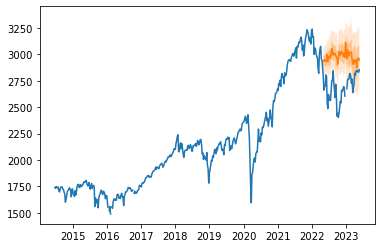

In [39]:
# Plot forecast
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [46]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_deepstate',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 

## MQ-CNN ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py))

MQ-CNN is a general probabilistic multi-step time series regression model. It exploits the expressiveness and temporal nature of Sequence-to-Sequence Neural Networks (e.g. recurrent and convolutional structures), the nonparametric nature of Quantile Regression and the efficiency of Direct Multi-Horizon Forecasting.


In [38]:
from gluonts.mx import MQCNNEstimator
from gluonts.mx import Trainer

In [ ]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
num_layers=2
hidden_size=20

# Trainer specs
max_epochs = 2
lr = 1e-1
weight_decay = 1e-4

In [ ]:
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers, 
    num_cells=hidden_size, 
    use_feat_static_cat=False,
    cardinality=[],
    trainer = Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)

In [ ]:
# Plot forecast
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_deepstate',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 